In [1]:
'''
This is the model that will be used to train the deep convolutional neaural network.

@Author : Aaron Ward 
'''
import tensorflow as tf
import os, os.path
import pandas as pd
import time
import numpy as np
from numpy import ndarray
import skimage
from skimage import data, io, filters, transform, exposure
import random
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

print('imported')

imported


In [2]:
TRAINING_DIR = '/data/training'
TESTING_DIR = '/data/testing'

MODEL_PATH = '/output/trained_model.ckpt'
SAVE = '/output/'

# Define initial variables
batch_size = 100
num_class = 6
num_epochs = 20
image_size = 50 # in pixels, square assumed

In [3]:
####################################### DATA PREPROCESSING - Labeling ################################################
'''
This function traverses throwe ach directory of training images
Two lists are made:
    - The RGB image values are added to the images list
    - For every photo in say the 'angry' directory of images, a 
      corresponding label is added to the label list

'''
def load_data(TRAINING_DIR):
    images = []
    labels = []
    directories = [d for d in os.listdir(TRAINING_DIR) 
                if os.path.isdir(os.path.join(TRAINING_DIR, d))]
    # Need to sort these because
    # floyd hum jumbled up the order
    directories = sorted(directories, key=int)

    # Traverse through each directory and make a list
    # of files names if they end in the PNG format
    for d in directories:
        label_directory = os.path.join(TRAINING_DIR, d)
        file_names = [os.path.join(label_directory, f) 
                        for f in os.listdir(label_directory) 
                          if f.endswith(".png")]
        #Traverse through each file, add the image data
        # and label to the 2 lists
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))

    return images, labels

images, labels = load_data(TRAINING_DIR)

print('data read...')

data read...


In [4]:
'''
Shuffle the entire dataset and labels
'''

from sklearn.utils import shuffle
images, labels = shuffle(images, labels)

In [5]:
'''
This cell is  for converting to one hot

'''
num_images = len(images)
images = np.array(images, object)
labels = np.array(labels, dtype = np.int32)

_labels = np.zeros((num_images, num_class))
_labels[np.arange(num_images), labels] = 1.0
labels = _labels

Angry = 0, fear = 1, happy = 2, neutral = 3, sadness = 4, suprise = 5


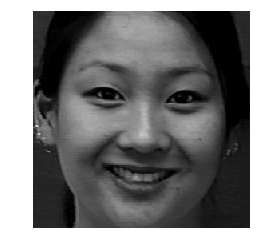

[ 0.  0.  1.  0.  0.  0.]


In [7]:
'''
Plot an image and label  of the same indices after being randomly
shuffled to confirm they represent the same expression
'''
print('Angry = 0, fear = 1, happy = 2, neutral = 3, sadness = 4, suprise = 5')

plt.axis('off')
plt.imshow(images[9], cmap='gray')
plt.subplots_adjust(wspace=0.1)
plt.show()


print(labels[9])


In [8]:
####################################### DATA PREPROCESSING - Labeling ################################################
'''
import test data and labels
'''
def load_test_data(TESTING_DIR):
    test_images = []
    test_labels = []
    directories = [d for d in os.listdir(TESTING_DIR) 
                if os.path.isdir(os.path.join(TESTING_DIR, d))]
    # Need to sort these because
    # floyd hum jumbled up the order
    directories = sorted(directories, key=int)

    # Traverse through each directory and make a list
    # of files names if they end in the PNG format
    for d in directories:
        label_directory = os.path.join(TESTING_DIR, d)
        file_names = [os.path.join(label_directory, f) 
                        for f in os.listdir(label_directory) 
                          if f.endswith(".png")]
        #Traverse through each file, add the image data
        # and label to the 2 lists
        for f in file_names:
            test_images.append(
                transform.resize(skimage.data.imread(f), (image_size, image_size) ) )
            test_labels.append(int(d))

    return test_images, test_labels

test_images, test_labels = load_test_data(TESTING_DIR)

print('Imported...')

/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Imported...


In [9]:
#Shuffle data and labels
test_images, test_labels = shuffle(test_images, test_labels)

In [10]:
'''
This cell is  for converting  to one hot
''' 

num_images = len(test_images)
test_images = np.stack( test_images )
test_labels = np.array( test_labels, dtype = np.int32 )

_test_labels = np.zeros((num_images, num_class))
_test_labels[np.arange(num_images), test_labels] = 1.0
test_labels = _test_labels

print('converted...')

converted...


Angry = 0, fear = 1, happy = 2, neutral = 3, sadness = 4, suprise = 5


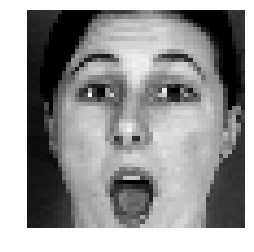

[ 0.  0.  0.  0.  0.  1.]


In [11]:
print('Angry = 0, fear = 1, happy = 2, neutral = 3, sadness = 4, suprise = 5')

plt.axis('off')
plt.imshow(test_images[5], cmap = 'gray')
plt.subplots_adjust(wspace=0.1)
plt.show()

print(test_labels[5])

In [12]:
####################################### DATA PREPROCESSING - Imaging #######################################
'''
This cell is for image downsampling and transformation
This is on the fly to resize the images to a 50x50 size
'''

print('Down scaling train images...')
images = [transform.resize(image, (50, 50)) for image in images]

# print('equalizing exposure...')
# images = [exposure.equalize_adapthist(image, clip_limit=0.0001)for image in images50]

print('Images Downscaled...')

Down scaling train images...


/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Images Downscaled...


In [13]:
'''
This cell is for initializing variables for the tensorflow session and 
placeholders for holding the data.

'''

# Initialize placeholders 
x = tf.placeholder(dtype = tf.float32, shape = [None, 50, 50], name='X_placeholder')
y = tf.placeholder(dtype = tf.float32, shape= [None, num_class],name="Y_placeholder")
is_training = tf.placeholder( dtype = tf.bool, shape = (), name = "is_training" )

#define variables for dropout
keep_rate = .8
keep_prop = tf.placeholder(tf.float32)
print('initialized')

initialized


In [14]:
'''
Network stucture using tensorflow slim to easily 
implement layers 

'''
import tensorflow.contrib.slim as slim

def convolutional_network_v2(x, is_training):
    net = tf.reshape(x, shape=[-1, 50, 50, 1]) # add channel dim

    with slim.arg_scope( [ slim.conv2d ],
            padding = "SAME",
            activation_fn = tf.nn.relu,
            stride = 1,
            weights_initializer = tf.truncated_normal_initializer(stddev=0.01),
            weights_regularizer = slim.l2_regularizer(0.0005),
            normalizer_fn = slim.batch_norm,
            normalizer_params = { 'fused' : False, 'trainable' : False, 'scale' : False, 'decay' : 0.9, :
                              'zero_debias_moving_mean' : True, 'is_training' : is_training }):
        
        net = slim.conv2d(net, 32, 3)
        net = slim.conv2d(net, 64, 3)
        net = slim.conv2d(net, 64, 3)
        net = slim.max_pool2d(net, 3, stride = 1 )
        net = slim.conv2d(net, 96, 3)
        net = slim.conv2d(net, 96, 3)
        net = slim.max_pool2d( net, 2, stride = 2)
        
        net = slim.conv2d(net, 128, 3)
        net = slim.conv2d(net, 128, 3)
        net = slim.max_pool2d( net, 2, stride = 2)

        net = slim.conv2d(net, 128, 3)
        net = slim.conv2d(net, 128, 3)
        net = slim.max_pool2d(net, 2, stride = 2)

        net = slim.conv2d(net, 128, 3)
        net = slim.max_pool2d(net, 2, stride = 1)
        
        net = slim.dropout(net, keep_prob = keep_rate, is_training = is_training )

    with slim.arg_scope([slim.fully_connected ], 
            weights_regularizer = slim.l2_regularizer(0.0005)):
        net = slim.flatten(net)
        output = slim.fully_connected(net, num_class, activation_fn = None)
        prediction = tf.nn.softmax(output, name = "Prediction" ) #Name this prediction to access it when restoring

        return output, prediction

In [16]:
'''
Shuffle the batches on the fly 

'''

def randomize(batch_x, batch_y):
    batch_x, batch_y = shuffle(batch_x, batch_y)
    return batch_x, batch_y
    

In [17]:
def train_network(x):
    output, prediction = convolutional_network_v2( x, is_training )

    #Use Softmax cross entropy for the loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = output))
    total_losses = tf.losses.get_total_loss( add_regularization_losses=True ) + loss
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) # needed for batch normalization
    with tf.control_dependencies(update_ops):
        train_op = tf.train.AdamOptimizer( learning_rate=0.002 ).minimize( total_losses )
    
    # Use these to print out predicted and actual labels
    pred_class = tf.argmax(prediction,1)
    label_class = tf.argmax(y, 1)
    
    #Accuracy Metric
    correct = tf.equal(tf.argmax(prediction,1),  tf.argmax(y, 1))
    acc = tf.reduce_mean(tf.cast(correct, 'float'))

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer()) # Initialize all the variables
        saver = tf.train.Saver()
    
        time_full_start = time.clock()
        print("RUNNING SESSION...")
        for epoch in range(num_epochs):
            train_batch_x = []
            train_batch_y = []
            epoch_loss= 0
            epoch_total_loss = 0
            accuracy = 0
            time_epoch_start = time.clock()
            i = 0
            number_of_batches = 0
            
            #For all images in the DS, batch into sizes of 100
            while i < len(images):
                start = i
                end = i + batch_size
                train_batch_x = images[start:end]
                train_batch_y = labels[start:end]
                
                #Randomize the batches even more
                train_batch_x, train_batch_y = randomize(train_batch_x, train_batch_y)
                
                #Feed batches into tensorflow
                op, ac, loss_value, total_loss_value, pred_classes, label_classes = \
                    sess.run([train_op, acc, loss, total_losses, pred_class, label_class ],
                             feed_dict={x: train_batch_x, y: train_batch_y, is_training : True})

                epoch_loss += loss_value
                epoch_total_loss += total_loss_value
                accuracy += ac
                i += batch_size
                number_of_batches += 1
            
            accuracy /= number_of_batches       
            print('Epoch:', epoch+1, 'total loss: ', epoch_total_loss  ,' loss: ', epoch_loss ,' acc: {:%}'.format(accuracy))
            
            time_epoch_end = time.clock()
            print('Time elapse: ', time_epoch_end - time_epoch_start)

        time_full_end = time.clock()
        print('Full time elapse:', time_full_end - time_full_start)

        if epoch_loss < 100:
            save_path = saver.save(sess, MODEL_PATH)
            print("Model saved in file: " , save_path)
        
        print('Accuracy:', acc.eval({x: test_images, y: test_labels, is_training : True }))
 #######################################################################################################################

            
            

In [18]:
train_network(x)


RUNNING SESSION...
Epoch: 1 total loss:  185.477717757  loss:  181.556583047  acc: 24.928571%
Time elapse:  32.71447500000001
Epoch: 2 total loss:  110.661992013  loss:  106.168049276  acc: 50.309522%
Time elapse:  30.089294999999993
Epoch: 3 total loss:  50.0105193555  loss:  45.1050315201  acc: 80.833331%
Time elapse:  30.38990800000002
Epoch: 4 total loss:  28.9389300197  loss:  23.6358199269  acc: 90.130954%
Time elapse:  29.77545599999999
Epoch: 5 total loss:  19.4134444594  loss:  13.815012645  acc: 94.571432%
Time elapse:  30.013195999999994
Epoch: 6 total loss:  16.9944194108  loss:  11.1213852987  acc: 95.357145%
Time elapse:  30.40331199999997
Epoch: 7 total loss:  17.7275241241  loss:  11.5340311453  acc: 95.523812%
Time elapse:  30.429442999999992
Epoch: 8 total loss:  13.3481315076  loss:  6.94241877645  acc: 97.321431%
Time elapse:  30.246095999999966
Epoch: 9 total loss:  12.0500211194  loss:  5.55784281064  acc: 97.690478%
Time elapse:  30.019460000000038
Epoch: 10 tota